In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [2]:
CAPUCHIN_FILE = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

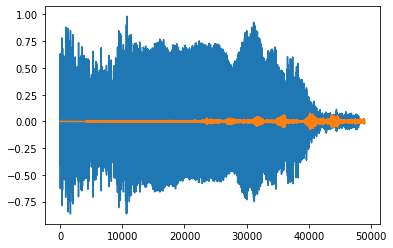

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
POS  = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')
NEG  = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips')

In [9]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC46077-2.wav'

In [13]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [14]:
print(len(positives))
print(len(negatives))

217
593


In [15]:
data = positives.concatenate(negatives)

In [16]:
print(len(data))

810


In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/bobwhite-quail-sound-16.wav',
 0.0)

In [18]:
lengths = []
for file in os.listdir(os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [19]:
lengths[0:5]

[64000, 48000, 48000, 56000, 56000]

In [20]:
len(lengths)

217

In [21]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [22]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [23]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [24]:
#Avg = lengths/Frequency
Highest_time = 80000/16000
Lowest_time = 32000/16000
Avg_time = 54156/16000
print(f'Highest duration of the birds call is: {Highest_time}s')
print(f'Lowest duration of the birds call is: {Lowest_time}s')
print(f'Average duration of the birds call is: {round(Avg_time,2)}s')

Highest duration of the birds call is: 5.0s
Lowest duration of the birds call is: 2.0s
Average duration of the birds call is: 3.38s


In [25]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [32]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [33]:
spectrogram, label = preprocess(filepath, label)


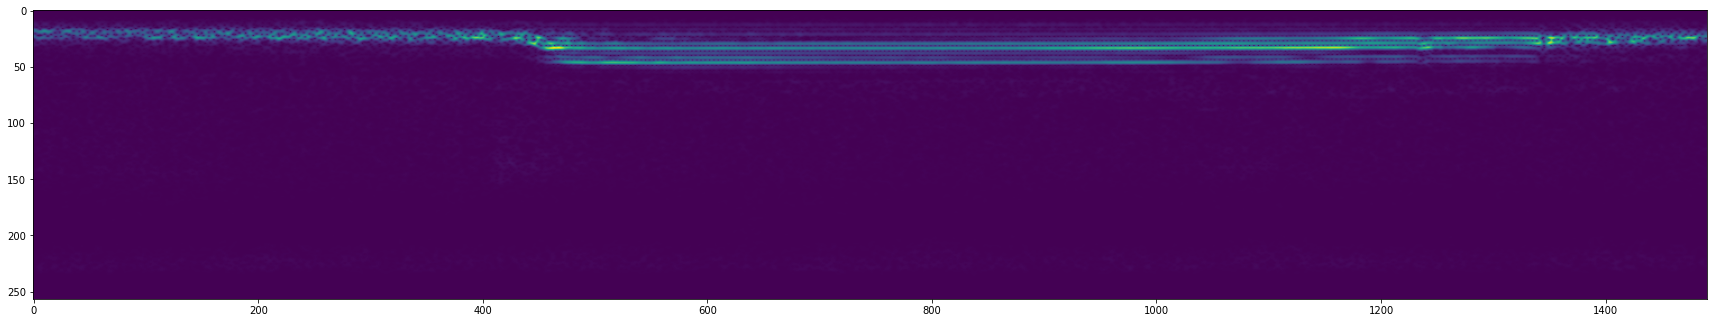

In [34]:
#Spectrogram of a capuchinbrid call
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [35]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [36]:
spectrogram, label = preprocess(filepath, label)

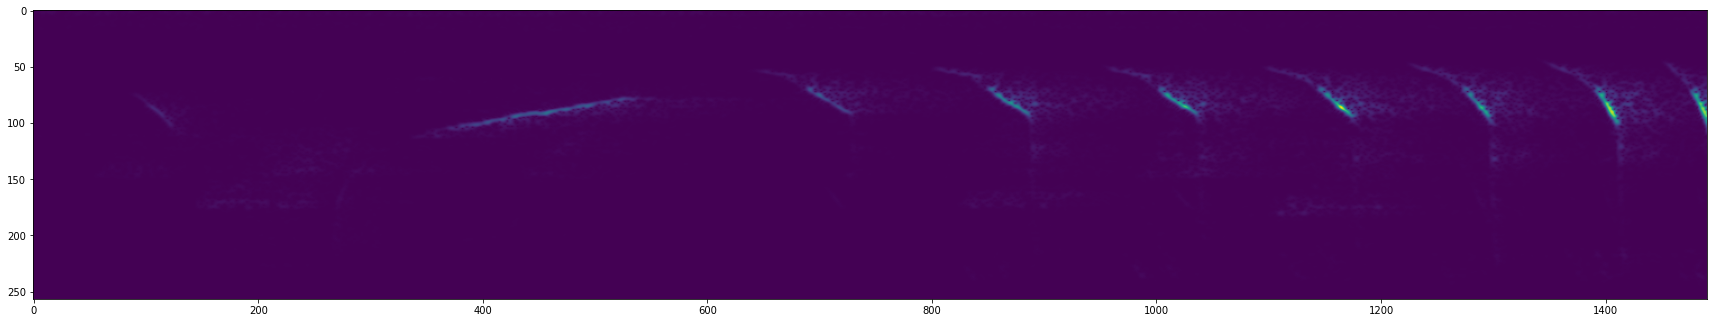

In [37]:
#Spectrogram of not a capuchinbrid call
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

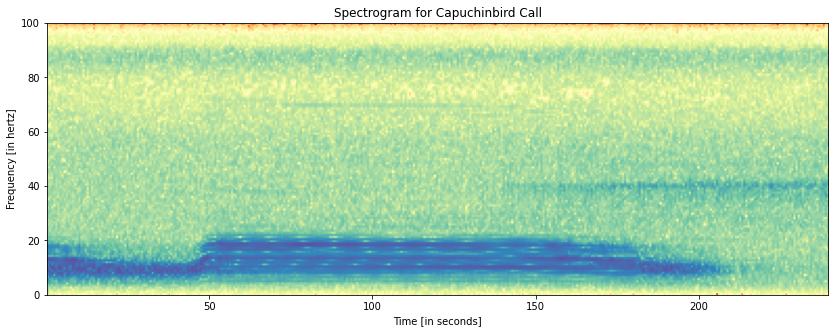

In [44]:
plt.figure(figsize=(14, 5))
plt.specgram(wave, Fs=200, cmap='Spectral')
plt.title('Spectrogram for Capuchinbird Call')
plt.ylim([0, 100])
plt.xlabel('Time [in seconds]')
plt.ylabel('Frequency [in hertz]')
plt.show()

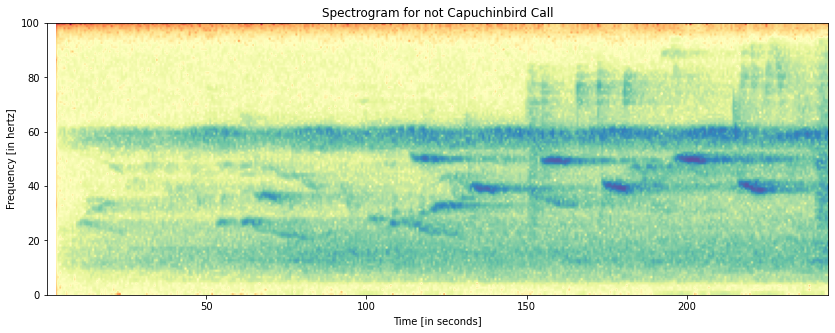

In [45]:
plt.figure(figsize=(14, 5))
plt.specgram(nwave, Fs=200, cmap='Spectral')
plt.title('Spectrogram for not Capuchinbird Call')
plt.ylim([0, 100])
plt.xlabel('Time [in seconds]')
plt.ylabel('Frequency [in hertz]')
plt.show()


In [38]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [46]:
train = data.take(36)
test = data.skip(36).take(15)

In [47]:
samples, labels = train.as_numpy_iterator().next()

2023-01-20 20:06:32.193931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 312 of 1000
2023-01-20 20:06:42.201336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 640 of 1000
2023-01-20 20:06:47.363416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [48]:
samples.shape

(16, 1491, 257, 1)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [50]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile(
    'Adam',
    loss='BinaryCrossentropy',
    metrics=[tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision()]
)

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [53]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 123s 3s/step - loss: 2.6517 - recall: 0.8831 - precision: 0.8608 - val_loss: 0.2453 - val_recall: 0.9825 - val_precision: 0.9655
Epoch 2/4
36/36 [==============================] - 118s 3s/step - loss: 0.1005 - recall: 0.9675 - precision: 0.9933 - val_loss: 0.0437 - val_recall: 0.9701 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 119s 3s/step - loss: 0.0055 - recall: 1.0000 - precision: 0.9935 - val_loss: 8.8134e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 118s 3s/step - loss: 0.0103 - recall: 0.9933 - precision: 0.9933 - val_loss: 0.0033 - val_recall: 0.9841 - val_precision: 1.0000


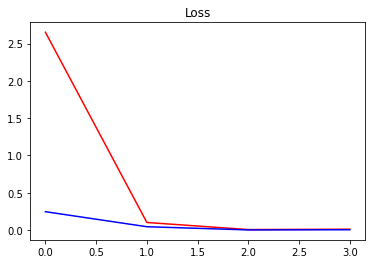

In [54]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

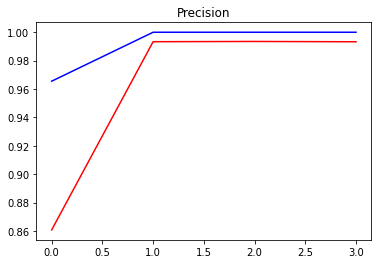

In [55]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

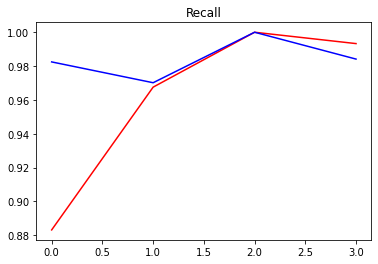

In [56]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [57]:
X_test, y_test = test.as_numpy_iterator().next()

In [58]:
yhat = model.predict(X_test)

In [59]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [60]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [61]:
mp3 = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_00.mp3')

In [62]:
wav = load_mp3_16k_mono(mp3)

In [63]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [64]:
samples, index = audio_slices.as_numpy_iterator().next()

In [65]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [66]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [67]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [68]:
from itertools import groupby

In [69]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [70]:
calls

7

In [72]:
results = {}
for file in os.listdir(os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
    FILEPATH = os.path.join('/kaggle','input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [78]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

In [79]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()


In [77]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])